# Bayesian Vector Autoregressive Models in NumPyro

In this notebook, we present how to implement and fit Bayesian Vector Autoregressive (VAR) models using [NumPyro](https://num.pyro.ai/en/stable/). We work out three components:

1. Specifying and fitting the model in NumPyro
2. Using the model to generate forecasts
3. Computing the Impulse Response Functions (IRFs)

We compare these three components with the ones obtained using the `statsmodels` implementation from the [Vector Autoregressions tsa.vector_ar](https://www.statsmodels.org/stable/vector_ar.html) tutorial.

## Prepare Notebook


In [1]:
from functools import partial

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from jax import jit, lax, random, vmap
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Load Data

We are going to use a dataset from the [`statsmodels` package](https://www.statsmodels.org/stable/datasets/index.html). Specifically, we will use the `macrodata` dataset from [Vector Autoregressions tsa.vector_ar](https://www.statsmodels.org/stable/vector_ar.html) tutorial. For the sake of reproducibility, we will keep the exact same code as in the tutorial.

In [2]:
def load_data() -> pd.DataFrame:
    mdata = sm.datasets.macrodata.load_pandas().data
    dates = mdata[["year", "quarter"]].astype(int).astype(str)
    quarterly = dates["year"] + "Q" + dates["quarter"]
    quarterly = dates_from_str(quarterly)
    mdata = mdata[["realgdp", "realcons", "realinv"]]
    mdata.index = pd.DatetimeIndex(quarterly, freq="QE")
    return np.log(mdata).diff().dropna()


data: pd.DataFrame = load_data()

We start by visualizing the data.

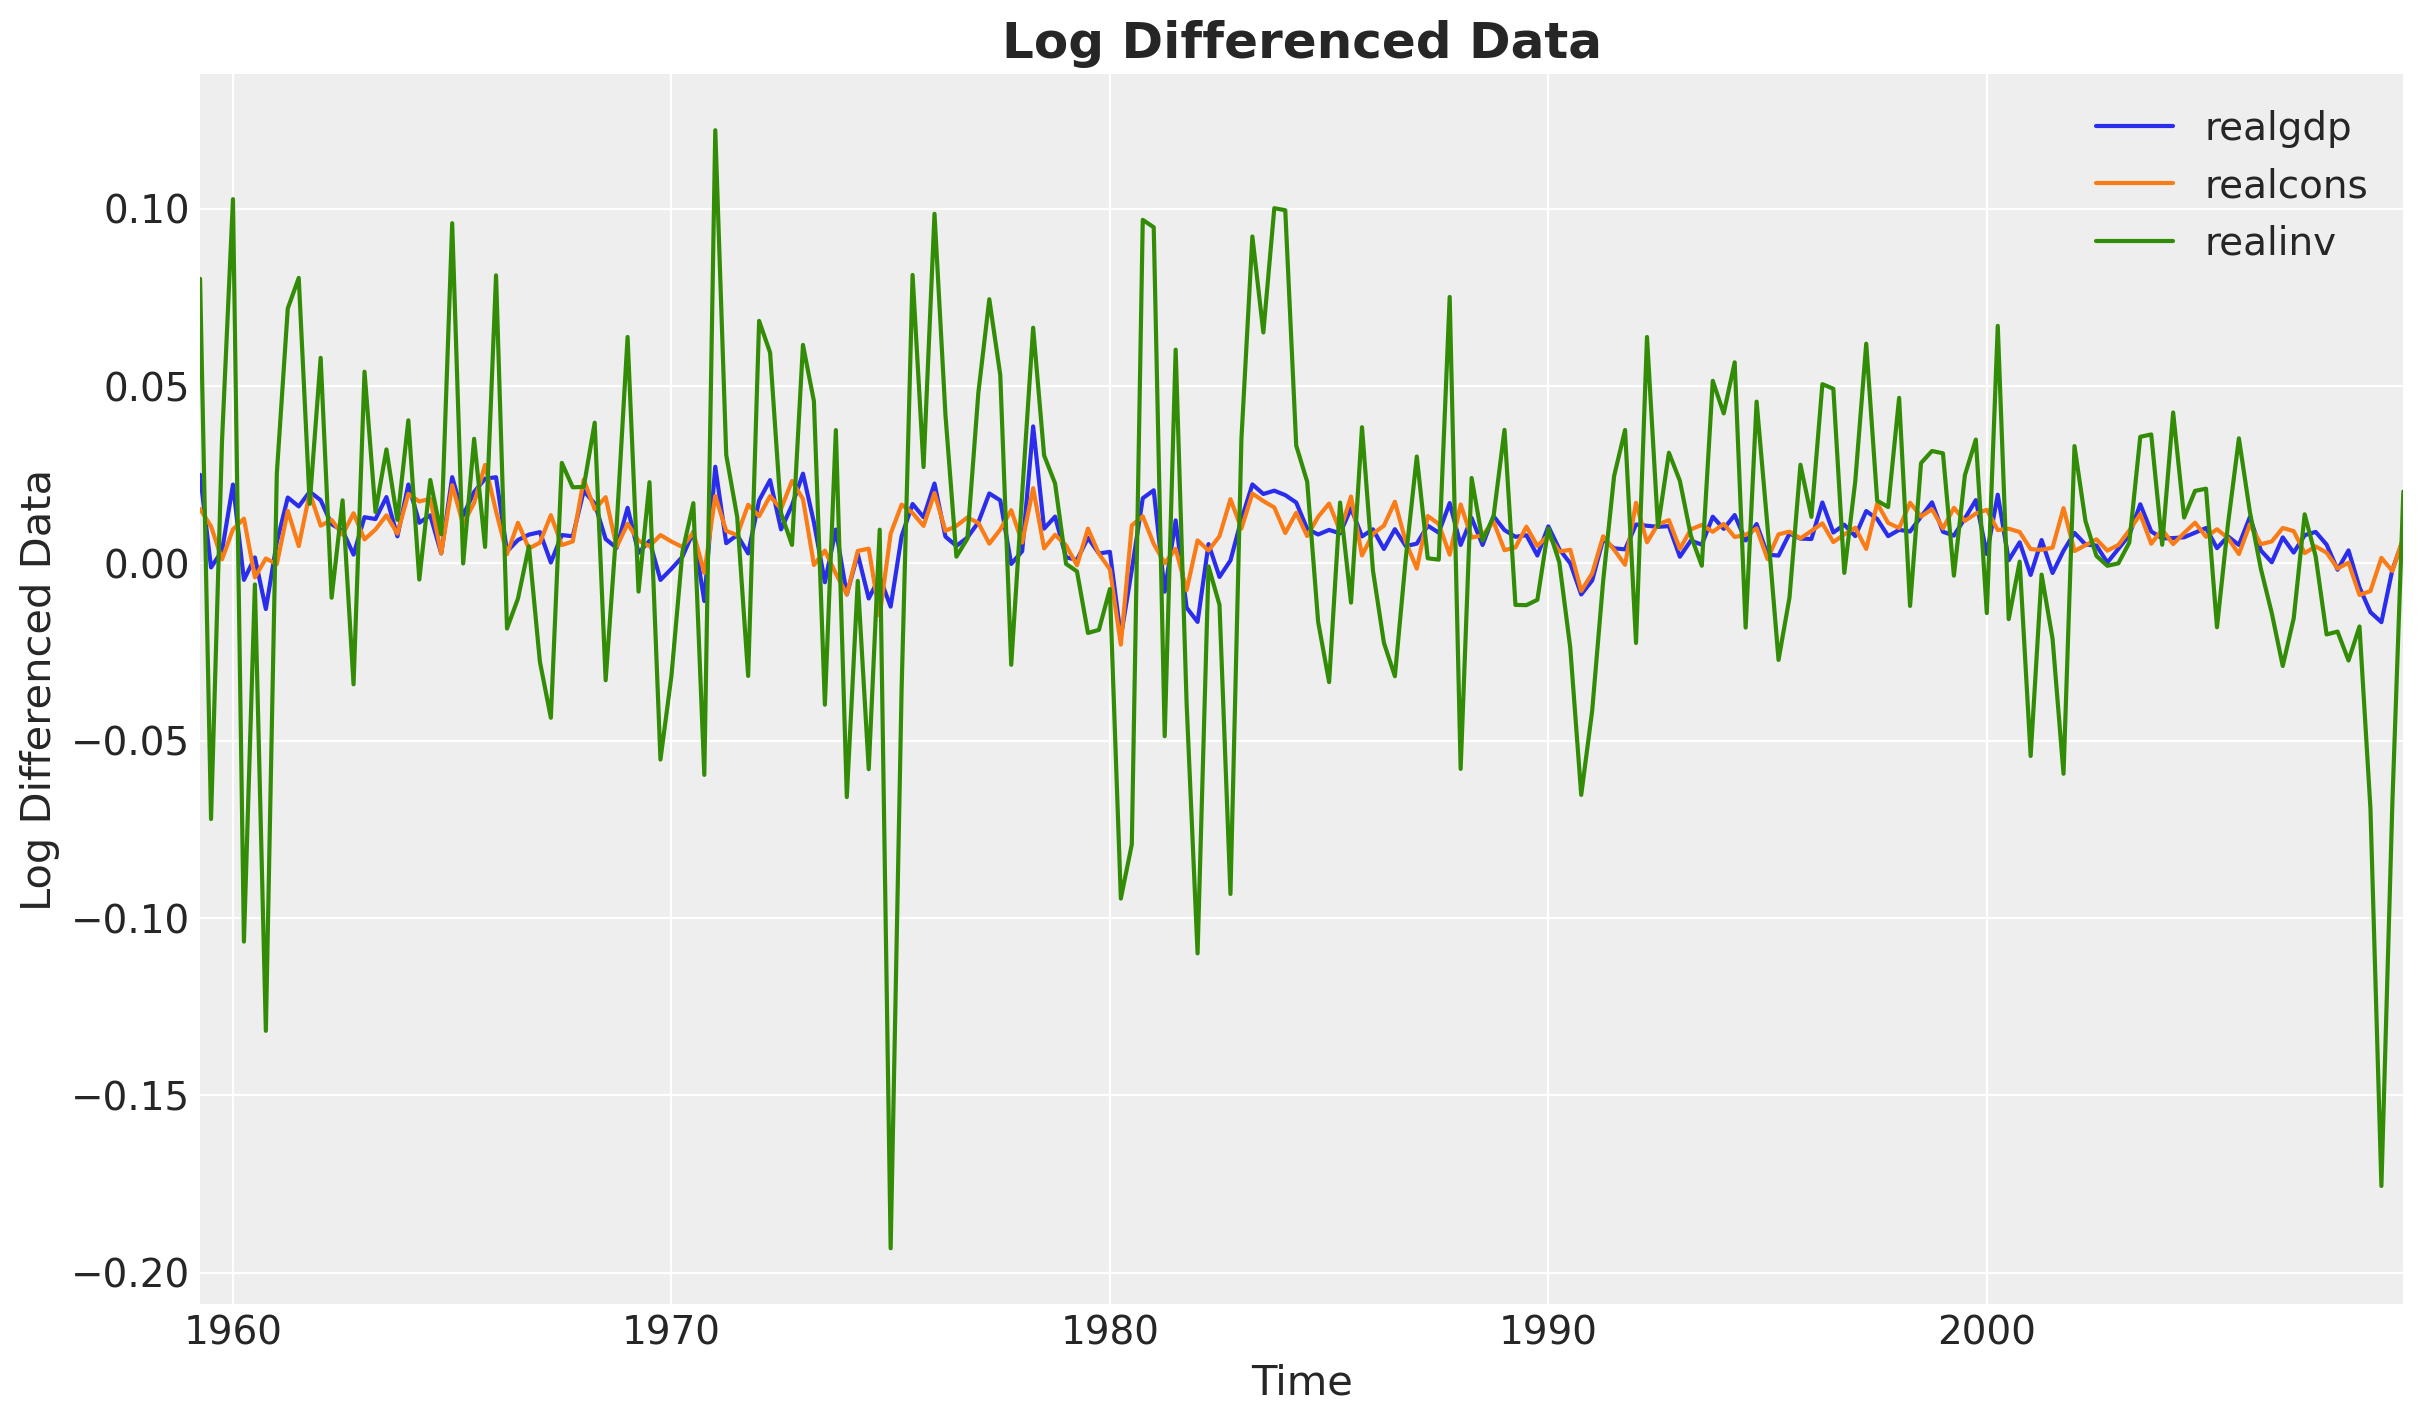

In [3]:
fig, ax = plt.subplots()
data.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Log Differenced Data")
ax.set_title("Log Differenced Data", fontsize=18, fontweight="bold");

It looks like the data is stationary.

## Fit VAR Model with Statsmodels

Recall that a $\text{VAR}(p)$ model can be written as:

$$
Y_t = c + \sum_{j=1}^{p} \Phi_j Y_{t-j} + \varepsilon_t,
$$

where $c$ is a vector of constants, $\Phi_j$ is the coefficient matrix for the $j$-th lag, and $\varepsilon_t$ is the error term which is a vector of i.i.d. normal random variables with mean $0$ and covariance matrix $\Sigma$. Each matrix $\Phi_j$ has dimensions $(k, k)$ where $k$ is the number of variables in the model. Let $\Phi = [\Phi_1, \Phi_2, \ldots, \Phi_p]$ be the tensor of coefficient matrices of shape $(p, k, k)$ so that we can write the model in vectorized form as:
$$
Y_t = c + \Phi \times \begin{bmatrix} Y_{t-1} \\ Y_{t-2} \\ \vdots \\ Y_{t-p} \end{bmatrix} + \varepsilon_t,
$$

Before implementing the model in Numpyro, we fit a VAR model using the `statsmodels` package to get the reference values.

In [4]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Oct, 2025
Time:                     14:59:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

## NumPyro Implementation

Next, we implement the model in Numpyro. The core idea is taken from the NumPyro docs: [Example: VAR(2) process](https://num.pyro.ai/en/stable/examples/var2.html). In our implementation, we make it in such a way that we vectorize the computation over the lags components (i.e. this works for lags larger than $2$).

### Vectorization over Lags

The vectorization is a bit tricky at first. So before jumping into the model, we consider a simple example. The idea is to vectorize the coefficient matrix $\Phi$ over the lags $j=1, \ldots, p$. Let us consider the case of $p=2$ and generate a synthetic matrix $\Phi$ as we mainly care about the computation and not the values themselves for now.

In [5]:
# number of variables (taken from the data)
n_vars = data.shape[1]
# number of lags
n_lags = 2

# generate a synthetic matrix
phi = jnp.arange(n_lags * n_vars * n_vars).reshape(n_lags, n_vars, n_vars)

phi

Array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]], dtype=int32)

For the matrix $\Phi$, the first dimension is the lags, the second dimension is the variables on the rows and the third dimension is the variables on the columns that we want to multiply and sum.



Next, we consider a synthetic lags vector which would represent the lags of the dependent variable $Y_t$.

In [6]:
y_lags = 2 * jnp.ones((n_lags, n_vars))

y_lags

Array([[2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

The tensor operation we want to perform is:

In [7]:
# Element-wise multiplication and sum over the third dimension (columns).
(phi * y_lags[..., jnp.newaxis]).sum(axis=(0, 2))

Array([ 66., 102., 138.], dtype=float32)

This can be achieved by using the [`einsum`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.einsum.html) function with a proper specification of the indices.

In [8]:
jnp.einsum("lij,lj->i", phi, y_lags)

Array([ 66., 102., 138.], dtype=float32)

We will use the einsum function to perform the operation in the NumPyro model.

### NumPyro Model

We are now ready to implement the VAR model in NumPyro. The idea is to use the scan function as in the previous example [Notes on an ARMA(1, 1) Model with NumPyro](https://juanitorduz.github.io/arma_numpyro/), see also the [PyData Amsterdam](https://amsterdam2024.pydata.org/cfp/talk/YBTSUV/) video [Time Series forecasting with NumPyro](https://www.youtube.com/watch?v=9Q6r2w0CDB0) for more details.

In [9]:
def model(y: Float[Array, "time vars"], n_lags: int, future: int = 0) -> None:
    # Get the number of time steps and variables
    n_time, n_vars = y.shape

    # --- Priors ---
    constant = numpyro.sample("constant", dist.Normal(loc=0, scale=1).expand([n_vars]))

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = jnp.einsum("...i,...ij->...ij", sigma, l_omega)

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    # The first dimension is the lags, the second dimension is the variables on the rows
    # and the third dimension is the variables on the columns that
    # we want to multiply and sum.
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    # --- Transition Function ---

    def transition_fn(carry: Array, _, name: str) -> tuple[Array, Array]:
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute lag contributions as a matrix product of phi and y_lags
        # (see the example above!)
        # Here the only trick is to reverse the phi lag coordinates. Why?
        # The first entry in the  initial `carry` vector `init_carry = y[:n_lags]`
        # is the oldest lag and the last entry is the newest lag.
        lag_contributions = jnp.einsum("lij,lj->i", phi[::-1], y_lags)
        # Compute VAR mean
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(name, dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma))

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    inference_fn = partial(transition_fn, name="y_pred")

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    with condition(data={"y_pred": y[n_lags:]}):
        scan(inference_fn, init=init_carry, xs=time_indices)

    if future > 0:
        prediction_fn = partial(transition_fn, name="y_future")
        scan(prediction_fn, init=y[-n_lags:], xs=jnp.arange(future))

Let's visualize the model:

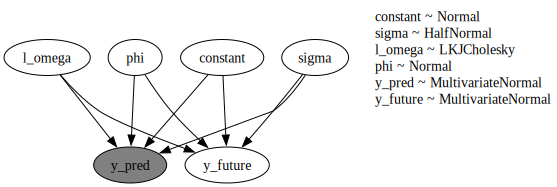

In [10]:
y: Float[Array, "time vars"] = jnp.array(data)

numpyro.render_model(
    model,
    model_kwargs={"y": y, "n_lags": 2, "future": 10},
    render_distributions=True,
    render_params=True,
)

Here we see the model structure and the two outputs: `y_pred` (inference) and `y_future` (prediction).

## Fit Numpyro Model

We now sample from the posterior distribution of the model using MCMC.

In [11]:
%%time

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

# Run inference
n_lags = 2
future = 30
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=n_lags, future=future)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 2min 22s, sys: 8.15 s, total: 2min 30s
Wall time: 39.8 s


Let's parse the samples to an ArviZ InferenceData object.

In [12]:
idata = az.from_numpyro(
    mcmc,
    coords={
        "var_1": data.columns,
        "var_2": data.columns,
        "lag": range(1, n_lags + 1),
        "future": range(data.shape[0], data.shape[0] + future),
    },
    dims={
        "constant": ["var_1"],
        "sigma": ["var_1"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
        "y_future": ["future", "var_1"],
    },
)

We can now visualize the traces.

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


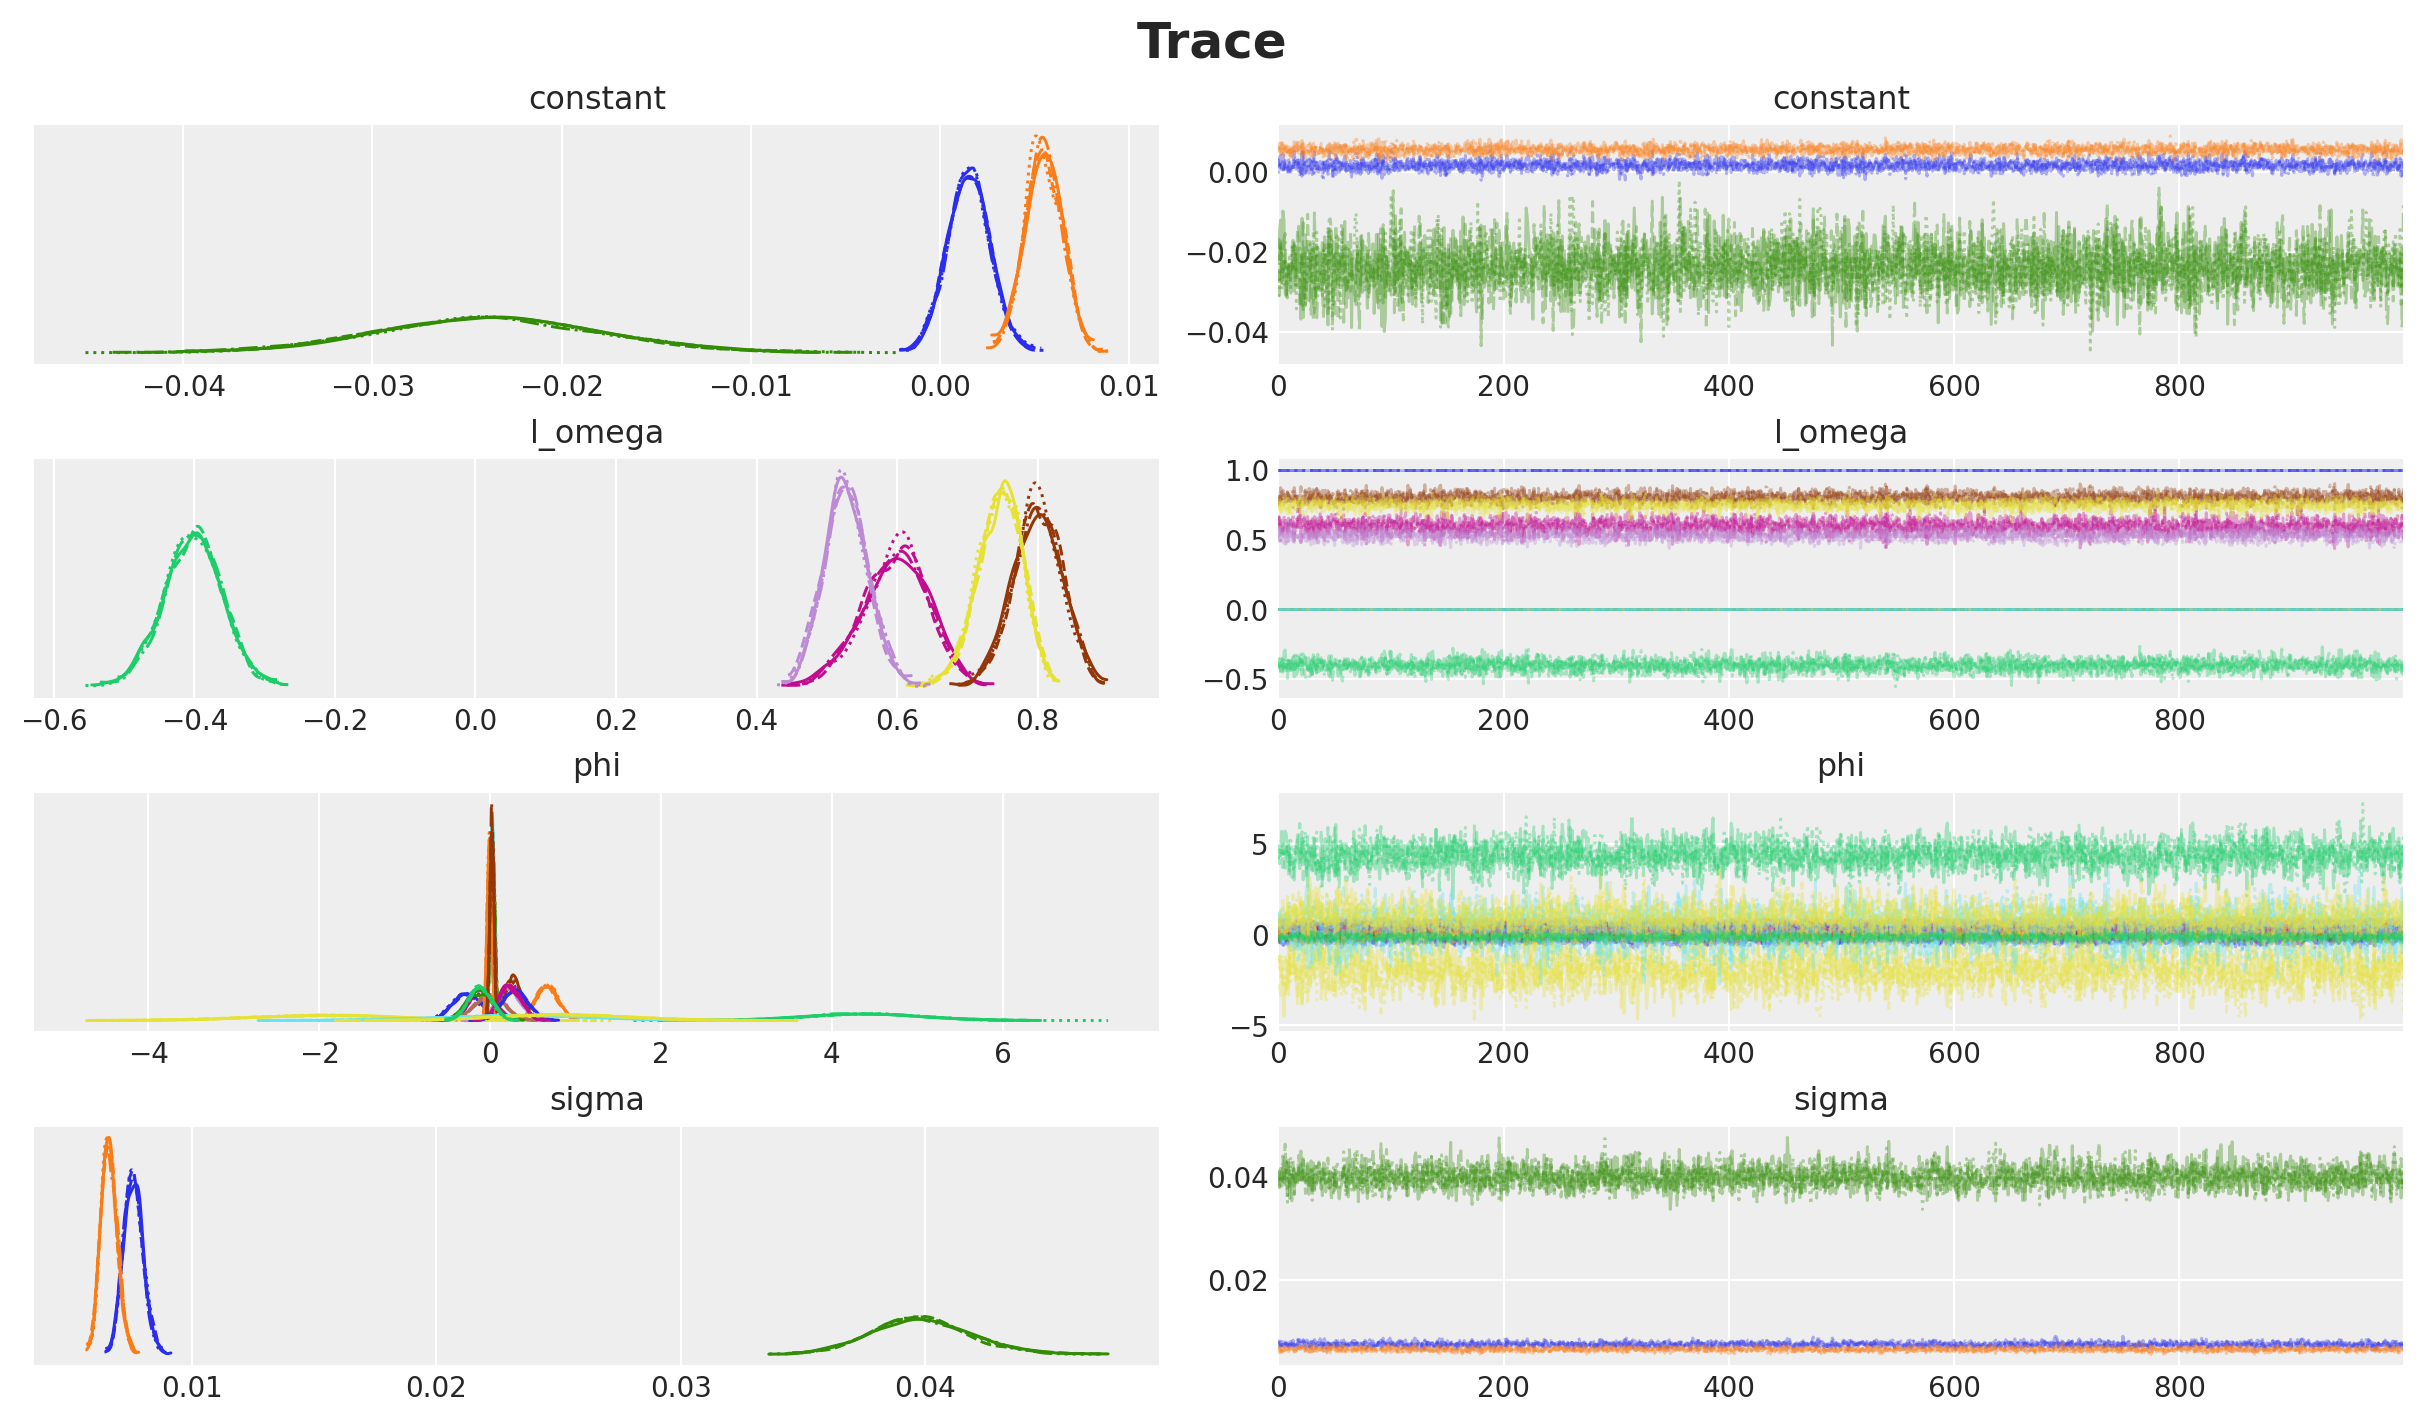

In [13]:
axes = az.plot_trace(
    data=idata,
    var_names=["~y_future"],
    compact=True,
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=18, fontweight="bold");

Overall, the chains seem to converge well.

## Parameter Comparison

We can manually inspect certain parameters mean values to see if they match the reference values from the `statsmodels` results.

In [14]:
(
    idata["posterior"]["phi"]
    .mean(dim=["chain", "draw"])
    .sel(var_1="realgdp")
    .to_dataframe()
    .sort_index()
)

var_1       phi
lag var_2                      
1   realcons  realgdp  0.668054
    realgdp   realgdp -0.272790
    realinv   realgdp  0.032299
2   realcons  realgdp  0.297236
    realgdp   realgdp -0.000703
    realinv   realgdp -0.006114

In [15]:
var_results.params["realgdp"].to_frame()

realgdp
const        0.001527
L1.realgdp  -0.279435
L1.realcons  0.675016
L1.realinv   0.033219
L2.realgdp   0.008221
L2.realcons  0.290458
L2.realinv  -0.007321

We do see the values are very close 🚀!

Similarly, we can look into the correlation matrix:

In [16]:
l_omega_mean = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

corr_mean = l_omega_mean.to_numpy() @ l_omega_mean.to_numpy().T

corr_mean

array([[1.        , 0.59747654, 0.745766  ],
       [0.59747654, 0.9966769 , 0.12399177],
       [0.745766  , 0.12399177, 0.9963025 ]], dtype=float32)

Which is very close to the correlation matrix from the `statsmodels` summary results above.

Finally, we can compare all the $\Phi$ parameters with the estimated posterior distributions.

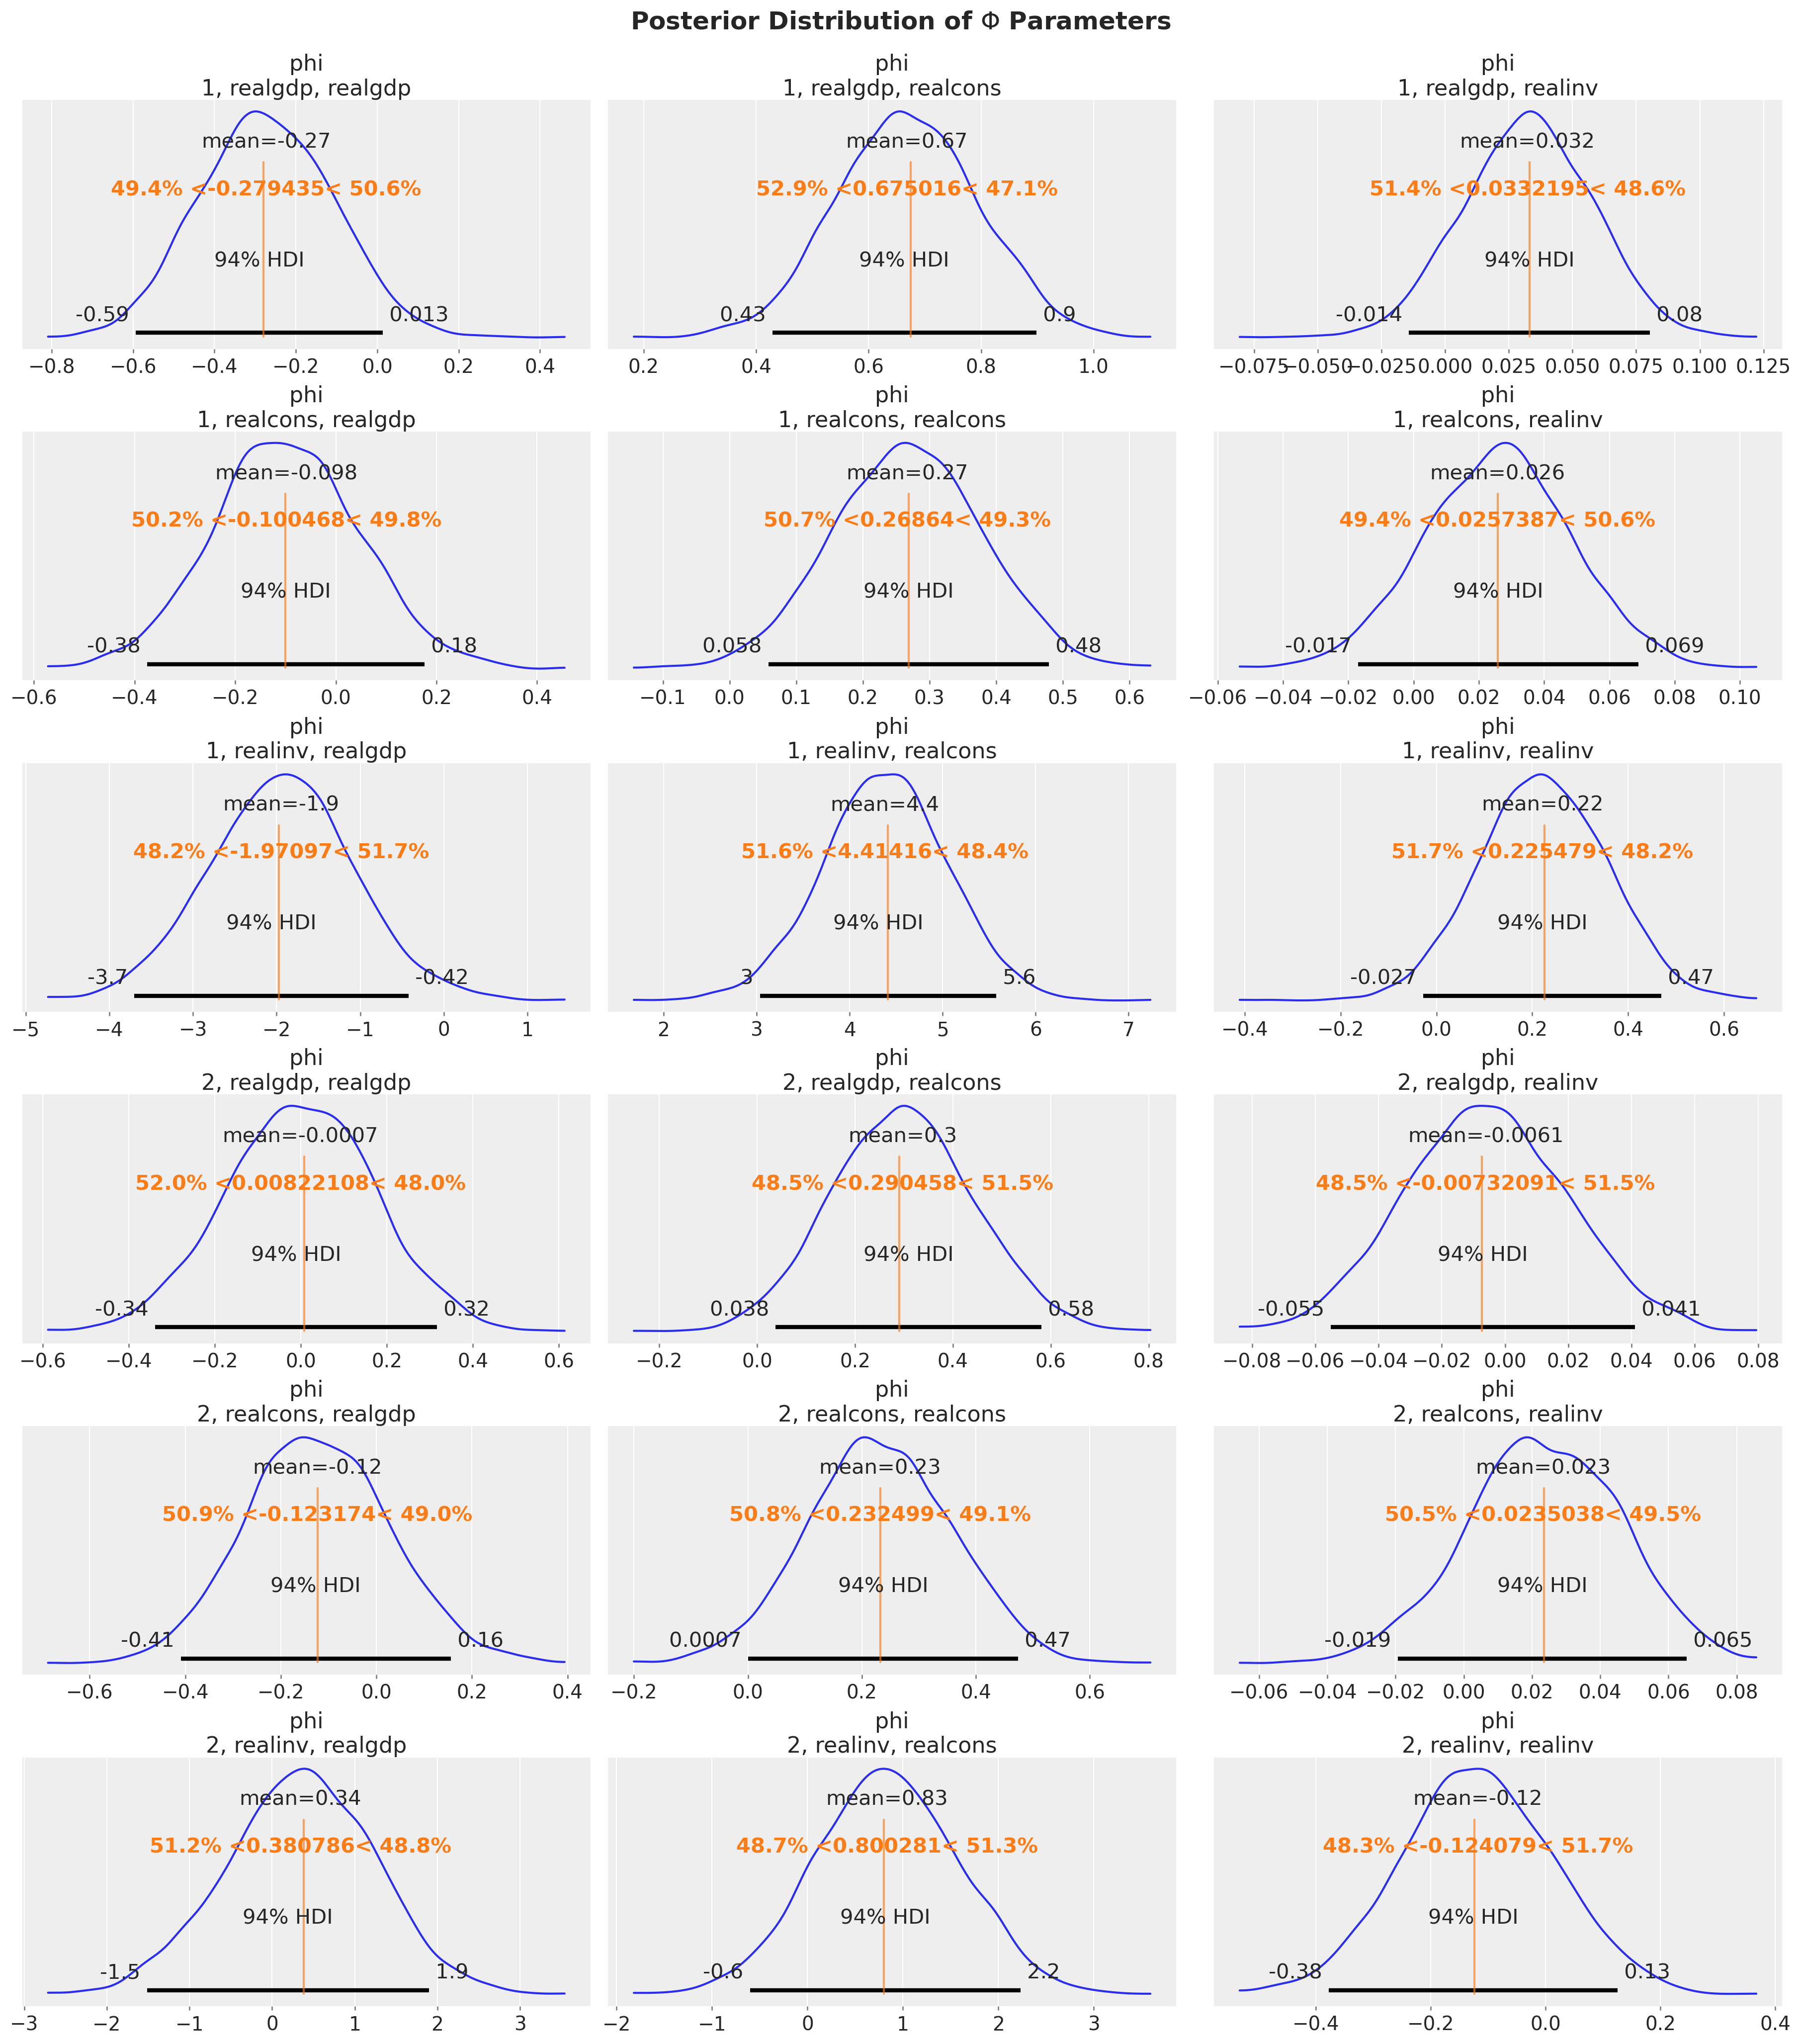

In [17]:
# Reference values from statsmodels VAR(2) results
# Simplified construction using list comprehension and f-strings
lags = range(2, 0, -1)
variables = data.columns

ref_vals_phi = {
    "phi": [
        {
            "lag": lag,
            "var_1": var_1,
            "var_2": var_2,
            "ref_val": var_results.params[var_1][f"L{lag}.{var_2}"],
        }
        for lag in lags
        for var_1 in variables
        for var_2 in variables
    ]
}

axes = az.plot_posterior(
    idata,
    var_names=["phi"],
    ref_val=ref_vals_phi,
    figsize=(18, 20),
)
fig = axes[0][0].figure
fig.suptitle(
    r"Posterior Distribution of $\Phi$ Parameters",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

All of the estimated parameters are very close to the reference values!

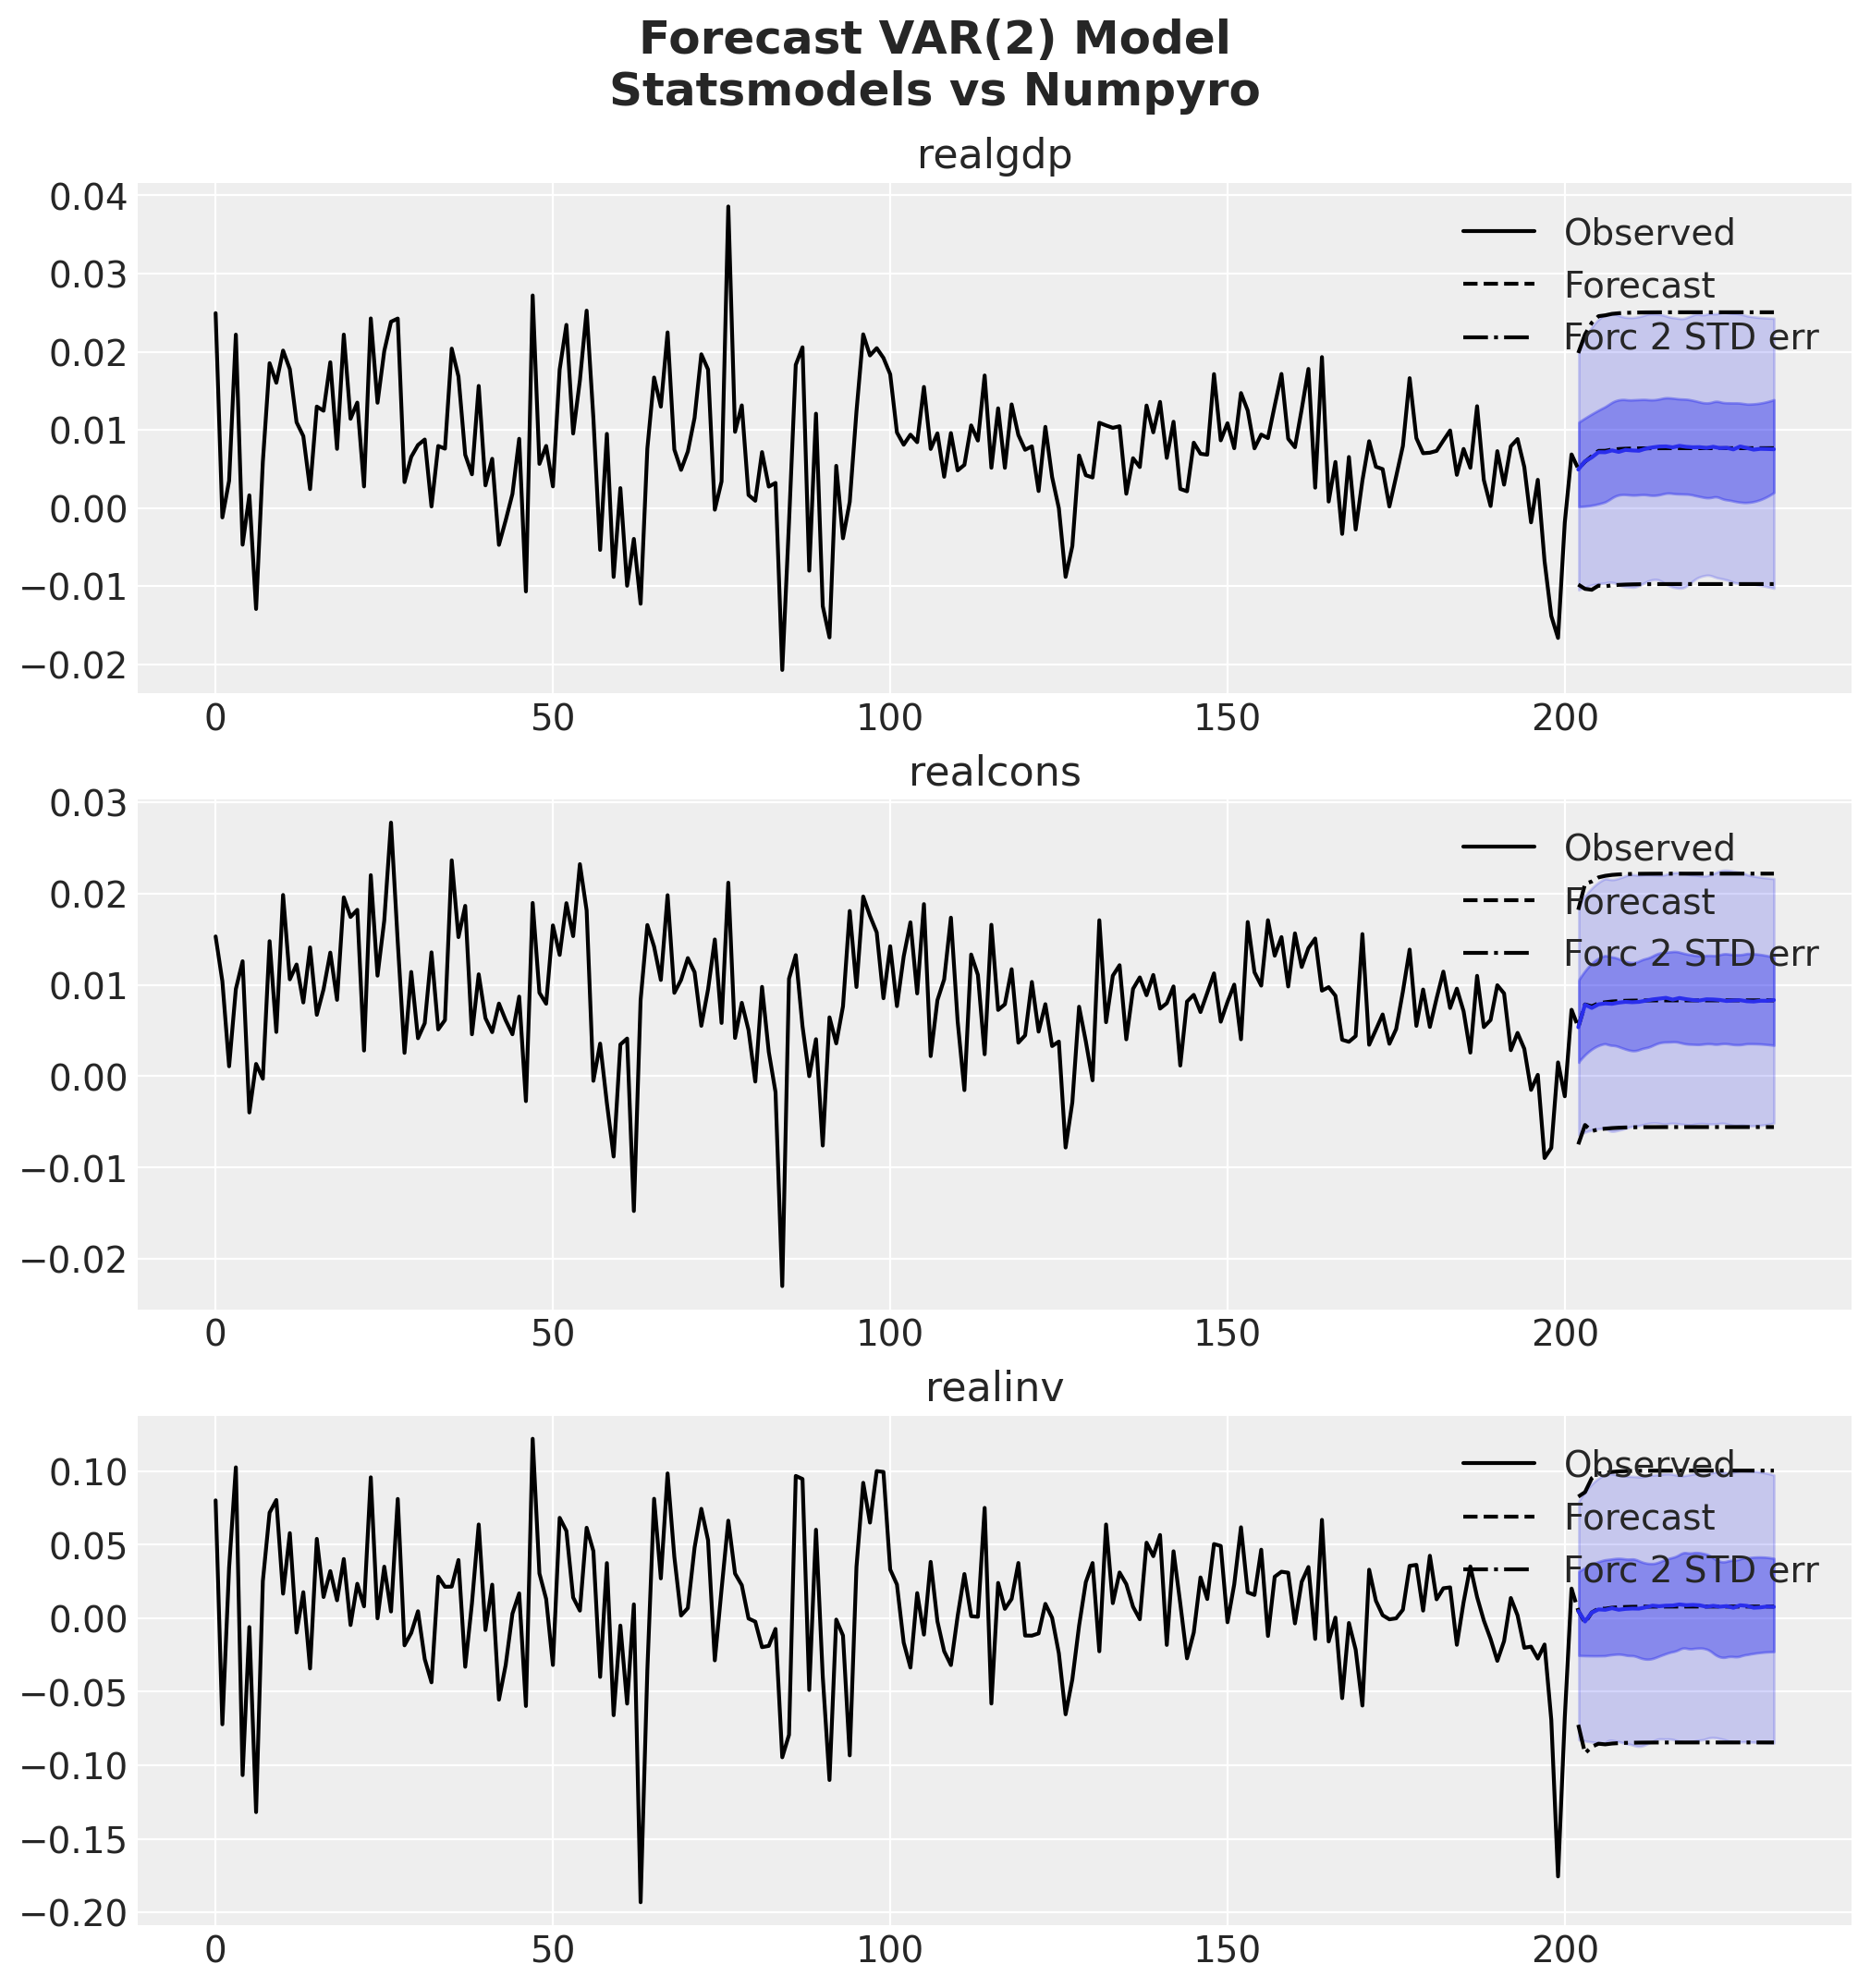

In [18]:
fig = var_results.plot_forecast(steps=future, alpha=0.05, plot_stderr=True)
axes = fig.get_axes()

t_future = idata["posterior"]["y_future"].coords["future"]

for var_idx, var in enumerate(data.columns):
    ax = axes[var_idx]
    for i, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            t_future,
            idata["posterior"]["y_future"].sel(var_1=var),
            color="C0",
            hdi_prob=hdi_prob,
            fill_kwargs={"alpha": 0.2 + 0.2 * i},
            ax=ax,
        )

    ax.plot(
        t_future,
        idata["posterior"]["y_future"].sel(var_1=var).mean(dim=["chain", "draw"]),
        color="C0",
    )

fig.suptitle(
    "Forecast VAR(2) Model\nStatsmodels vs Numpyro",
    fontsize=18,
    fontweight="bold",
    y=1.06,
);

## Impulse Response Functions (IRFs)?

After fitting a VAR model, we often want to understand **how the system responds to shocks**. This is where Impulse Response Functions (IRFs) come in.

### The Intuition

Imagine you have three economic variables: GDP, consumption, and investment. Now suppose there's an unexpected shock to GDP (e.g., a sudden policy change). An IRF answers questions like:
- How does GDP itself respond over time?
- How does consumption react to this GDP shock?
- What happens to investment in subsequent periods?

IRFs trace out the **dynamic response** of each variable to a one-time shock in another variable, holding all else constant.

### From VAR to MA Representation

Recall our $\text{VAR}(p)$ model:

$$Y_t = c + \sum_{j=1}^{p} \Phi_j Y_{t-j} + \varepsilon_t$$

This model tells us how current values depend on past values. But to compute IRFs, we need the **Moving Average (MA) representation**, which expresses current values in terms of current and past shocks:

$$Y_t = \mu + \sum_{i=0}^{\infty} \Psi_i \varepsilon_{t-i}$$

where:
- $\Psi_0 = I$ (identity matrix - a shock has immediate unit effect on itself)
- $\Psi_i$ are the **MA coefficient matrices** that tell us the response at time $i$ to a shock at time 0
- These $\Psi_i$ matrices **are** the IRFs!

### The Recursive Algorithm

A key result of the VAR model is that we can compute the $\Psi_i$ matrices recursively from the VAR coefficients $\Phi_j$:

$$\Psi_0 = I$$

$$\Psi_i = \sum_{j=1}^{\min(i, p)} \Psi_{i-j} \Phi_j \quad \text{for } i \geq 1$$

This means:
- At time 0: The response is just the identity (shock = response)
- At time 1: $\Psi_1 = \Psi_0 \Phi_1 = \Phi_1$ (first-order effects)
- At time 2: $\Psi_2 = \Psi_1 \Phi_1 + \Psi_0 \Phi_2$ (effects compound!)
- And so on...

Each $\Psi_i[k, j]$ tells us: **"What is the response of variable k at time i to a unit shock in variable j at time 0?"**

### Deriving the Recursive Formula

The recursive formula for computing IRFs comes from substituting the VAR representation into itself. Here's the intuition:

Starting with the VAR(p) model:

$$Y_t = c + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2} + \cdots + \Phi_p Y_{t-p} + \varepsilon_t$$

We want to express $Y_t$ purely in terms of shocks $\varepsilon_t, \varepsilon_{t-1}, \varepsilon_{t-2}, \ldots$

**The key insight**: Keep substituting past values with their own VAR equations!

- At $t$: $Y_t = c + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2} + \cdots + \varepsilon_t$
- For $Y_{t-1}$: substitute its VAR equation, which brings in $\varepsilon_{t-1}$
- For $Y_{t-2}$: substitute its VAR equation, which brings in $\varepsilon_{t-2}$
- Continue infinitely...

After all substitutions and collecting terms by shock timing, we get:

$$Y_t = \mu + \varepsilon_t + \Psi_1 \varepsilon_{t-1} + \Psi_2 \varepsilon_{t-2} + \cdots$$

The recursion emerges because:

- The coefficient on $\varepsilon_{t-i}$ (which is $\Psi_i$) depends on how $Y_{t-1}, Y_{t-2}, \ldots$ responded to that same shock in earlier periods
- Specifically: $\Psi_i$ accumulates contributions from $\Phi_1 \Psi_{i-1}$ (via $Y_{t-1}$), $\Phi_2 \Psi_{i-2}$ (via $Y_{t-2}$), etc.

This gives us the recursive relationship above.

The $\min(i, p)$ appears because we only have $p$ lags in the VAR - there's no $\Phi_j$ for $j > p$.


### Implementation Strategy

We will implement the impulse response function using the `compute_irf` function below. This function implements this recursive algorithm efficiently using:

1. **JAX's `lax.scan`** for fast, functional iteration
2. **JIT compilation** for maximum speed
3. **Vectorization** to compute all responses simultaneously across all posterior samples

Let's see how it works! 👇


## Impulse Response Functions

In [19]:
def compute_irf(
    phi: Float[Array, "*sample n_lags n_vars n_vars"],
    n_steps: int,
    shock_size: float = 1.0,
) -> Float[Array, "*sample n_steps n_vars n_vars"]:
    """
    Compute MA(∞) representation of VAR(p) process (non-orthogonalized IRF).

    Implements the recursive algorithm using jax.lax.scan:

    Ψ_0 = I

    Ψ_i = sum_{j=1}^{min(i,p)} Ψ_{i-j} @ Φ_j for i >= 1

    Parameters
    ----------
    phi : array of shape (n_lags, n_vars, n_vars)
        VAR coefficient matrices Φ_j. phi[j-1] corresponds to Φ_j.
    n_steps : int
        Number of MA coefficient matrices to compute.
    shock_size : float, default=1.0
        Scaling factor for identity matrix at t=0.

    Returns
    -------
    psi : array of shape (n_steps, n_vars, n_vars)
        MA representation (IRF matrices). psis[i, :, j] is the response of all variables
        at time i to a unit shock to variable j at time 0.
    """

    n_lags, n_vars, _ = phi.shape

    def scan_fn(carry: Array, i: Array) -> tuple[Array, Array]:
        """
        Compute Ψ_i from previous MA matrices.

        carry: Array of shape (n_lags, n_vars, n_vars) containing the last n_lags MA
            matrices. carry[0] is Ψ_{i-1}, carry[1] is Ψ_{i-2}, ..., carry[n_lags - 1]
            is Ψ_{i-n_lags}
        i: current time step
        """
        # Compute Ψ_i = sum_{j=1}^{min(i,p)} Ψ_{i-j} @ Φ_j
        # We need to handle the case where i < n_lags (early steps)

        # carry[0] is Ψ_{i-1}, carry[1] is Ψ_{i-2}, etc.
        # phi[0] is Φ_1 (lag 1), phi[1] is Φ_2 (lag 2), etc.

        # For each lag j from 1 to min(i, n_lags):
        #   Ψ_{i-j} is carry[j - 1]
        #   Φ_j is phi[j - 1]

        # Create a mask to only sum over valid lags (up to min(i, n_lags))
        valid_lags = jnp.arange(n_lags) < jnp.minimum(i, n_lags)

        # Compute contributions: Ψ_{i-j} @ Φ_j for each j
        # carry[j] @ phi[j] for j in range(n_lags)
        contributions = jnp.einsum("jkl,jlm->jkm", carry, phi)

        # Mask invalid contributions and sum
        psi_i = jnp.sum(contributions * valid_lags[:, None, None], axis=0)

        # Update carry: shift everything by 1 and add new Ψ_i at the front
        new_carry = jnp.concatenate([psi_i[None, :, :], carry[:-1]], axis=0)

        return new_carry, psi_i

    # Initialize carry with zeros and set Ψ_0 = I at the front
    psi_0 = shock_size * jnp.eye(n_vars)
    init_carry = jnp.concatenate(
        [psi_0[None, :, :], jnp.zeros((n_lags - 1, n_vars, n_vars))], axis=0
    )

    # Run scan for steps 1 to n_steps - 1
    if n_steps == 1:
        return psi_0[None, :, :]

    time_steps = jnp.arange(1, n_steps)
    _, psis_rest = lax.scan(scan_fn, init_carry, time_steps)

    # Concatenate Ψ_0 with the rest
    return jnp.concatenate([psi_0[None, :, :], psis_rest], axis=0)


compute_irf_jit = jit(
    compute_irf,
    static_argnames=["n_steps", "shock_size"],  # For this example is enough
)

Let's verify that this implementation matches the statsmodels results.

In [20]:
n_irf_steps = 10

phi_sm = jnp.array(var_results.coefs)

# Get statsmodels IRF (ma_rep)
irf_sm = var_results.ma_rep(maxn=n_irf_steps - 1)

# Compute IRF with scan-based function
irf_jax_scan = compute_irf_jit(phi_sm, n_steps=n_irf_steps)

# Check results match
assert jnp.allclose(irf_jax_scan, irf_sm)

Great! We have a working implementation of the impulse response function! We can now compute the IRFs for all posterior samples. To do this we need to vectorize the `compute_irf_jit` function.

In [21]:
# Get all posterior samples (flatten chain and draw dimensions)
phi_samples = jnp.array(idata["posterior"]["phi"].stack(sample=["chain", "draw"]))  # noqa PD013
# Transpose to get samples as first dimension
phi_samples = jnp.transpose(
    phi_samples, (3, 0, 1, 2)
)  # Shape: (n_samples, n_lags, n_vars, n_vars)


# Create a vmapped version that computes IRF for each posterior sample
# vmap over the first axis (samples)
compute_irf_vmap = vmap(compute_irf_jit, in_axes=(0, None, None))

# Compute IRFs for all posterior samples
irf_samples = compute_irf_vmap(phi_samples, n_irf_steps, 1.0)

# Create an xarray DataArray to store the IRFs
irf_samples_xr = xr.DataArray(
    data=jnp.expand_dims(irf_samples, axis=0),
    dims=("chain", "draw", "step", "var_1", "var_2"),
    coords={
        "chain": np.arange(1),
        "draw": np.arange(irf_samples.shape[0]),
        "step": np.arange(n_irf_steps),
        "var_1": data.columns,
        "var_2": data.columns,
    },
)

We can now plot the IRFs generated from the posterior samples and compare them against the IRFs from the `statsmodels` model.

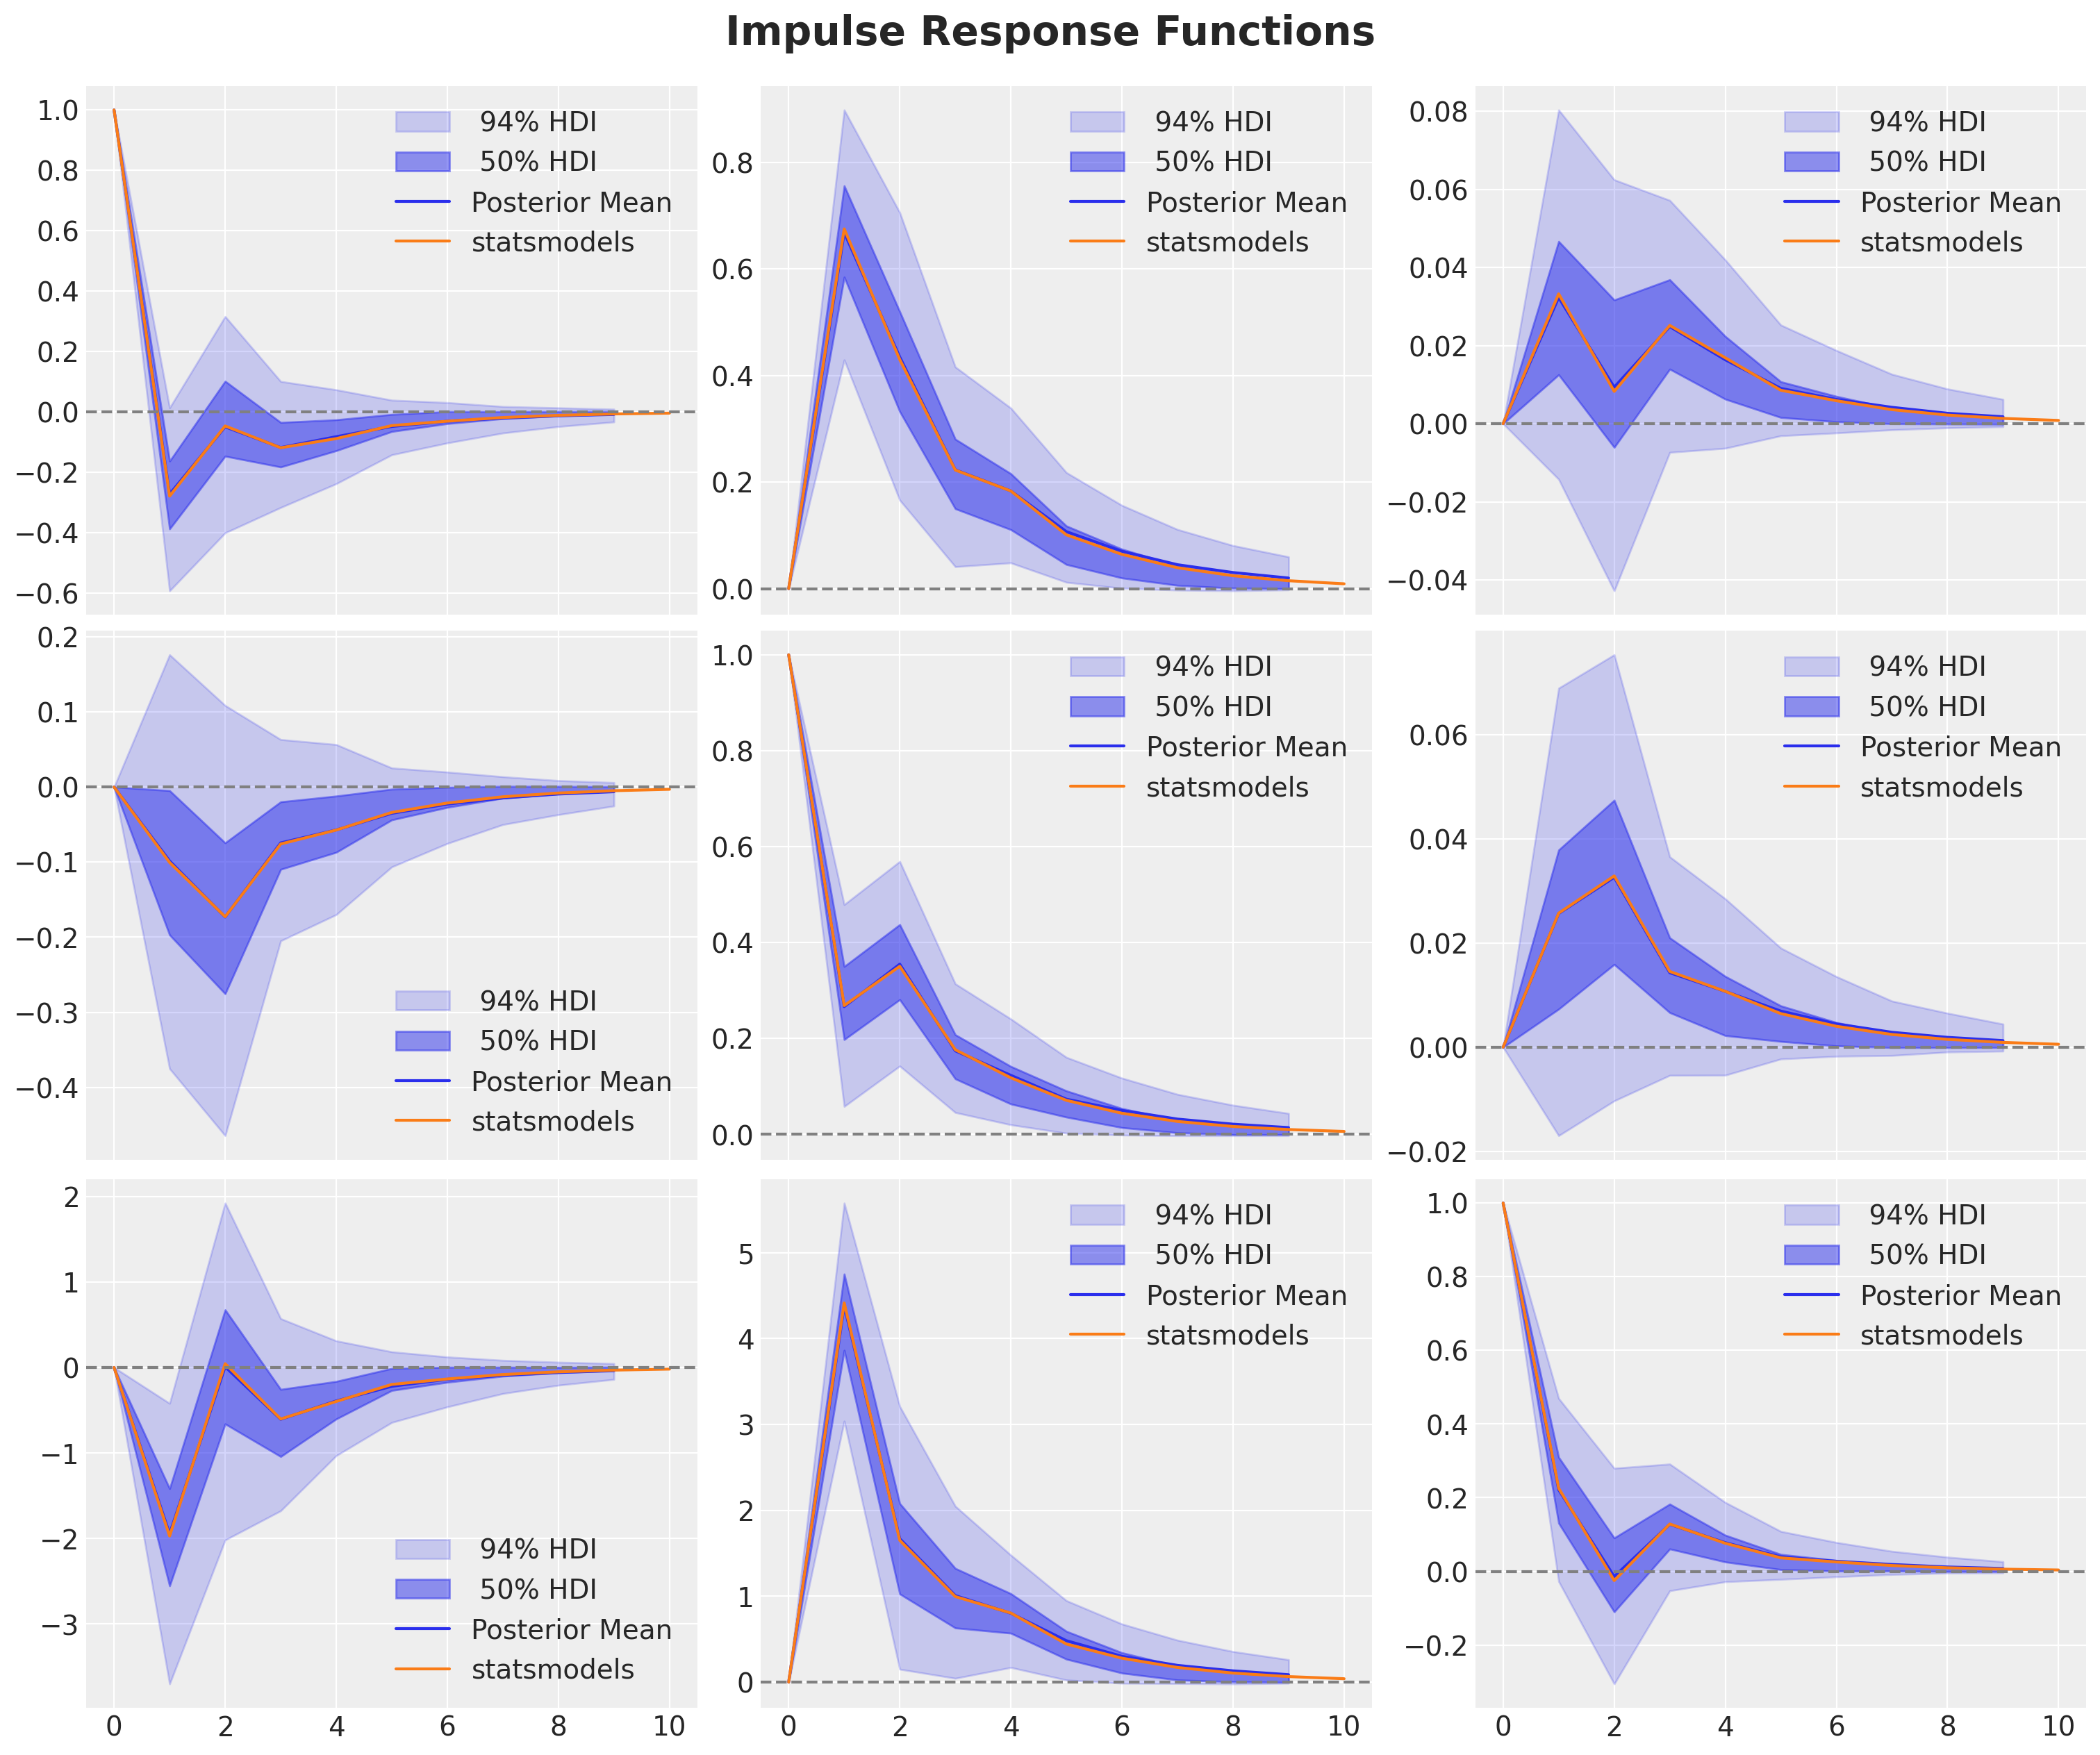

In [22]:
var_irf = var_results.irf(n_irf_steps)

fig, axes = plt.subplots(
    nrows=len(data.columns),
    ncols=len(data.columns),
    figsize=(15, 12),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, var_1 in enumerate(data.columns):
    for j, var_2 in enumerate(data.columns):
        ax = axes[i, j]
        for k, hdi_prob in enumerate([0.94, 0.5]):
            az.plot_hdi(
                range(n_irf_steps),
                irf_samples_xr.sel(var_1=var_1, var_2=var_2),
                hdi_prob=hdi_prob,
                color="C0",
                smooth=False,
                fill_kwargs={
                    "alpha": 0.2 + 0.3 * k,
                    "label": f"{hdi_prob: .0%} HDI",
                },
                ax=ax,
            )
        ax.plot(
            range(n_irf_steps),
            irf_samples_xr.sel(var_1=var_1, var_2=var_2)
            .mean(dim=("chain", "draw"))
            .to_numpy()
            .flatten(),
            color="C0",
            label="Posterior Mean",
        )
        ax.plot(var_irf.irfs[:, i, j], c="C1", label="statsmodels")
        ax.axhline(0, color="gray", linestyle="--")
        ax.legend()

fig.suptitle("Impulse Response Functions", fontsize=21, fontweight="bold", y=1.04);

We get the same results as the `statsmodels` model! 🎉

Observe that `statsmodels` generates similar plots (with similar uncertainty bounds).

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/plotting.py:182: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(**passed_kwds)


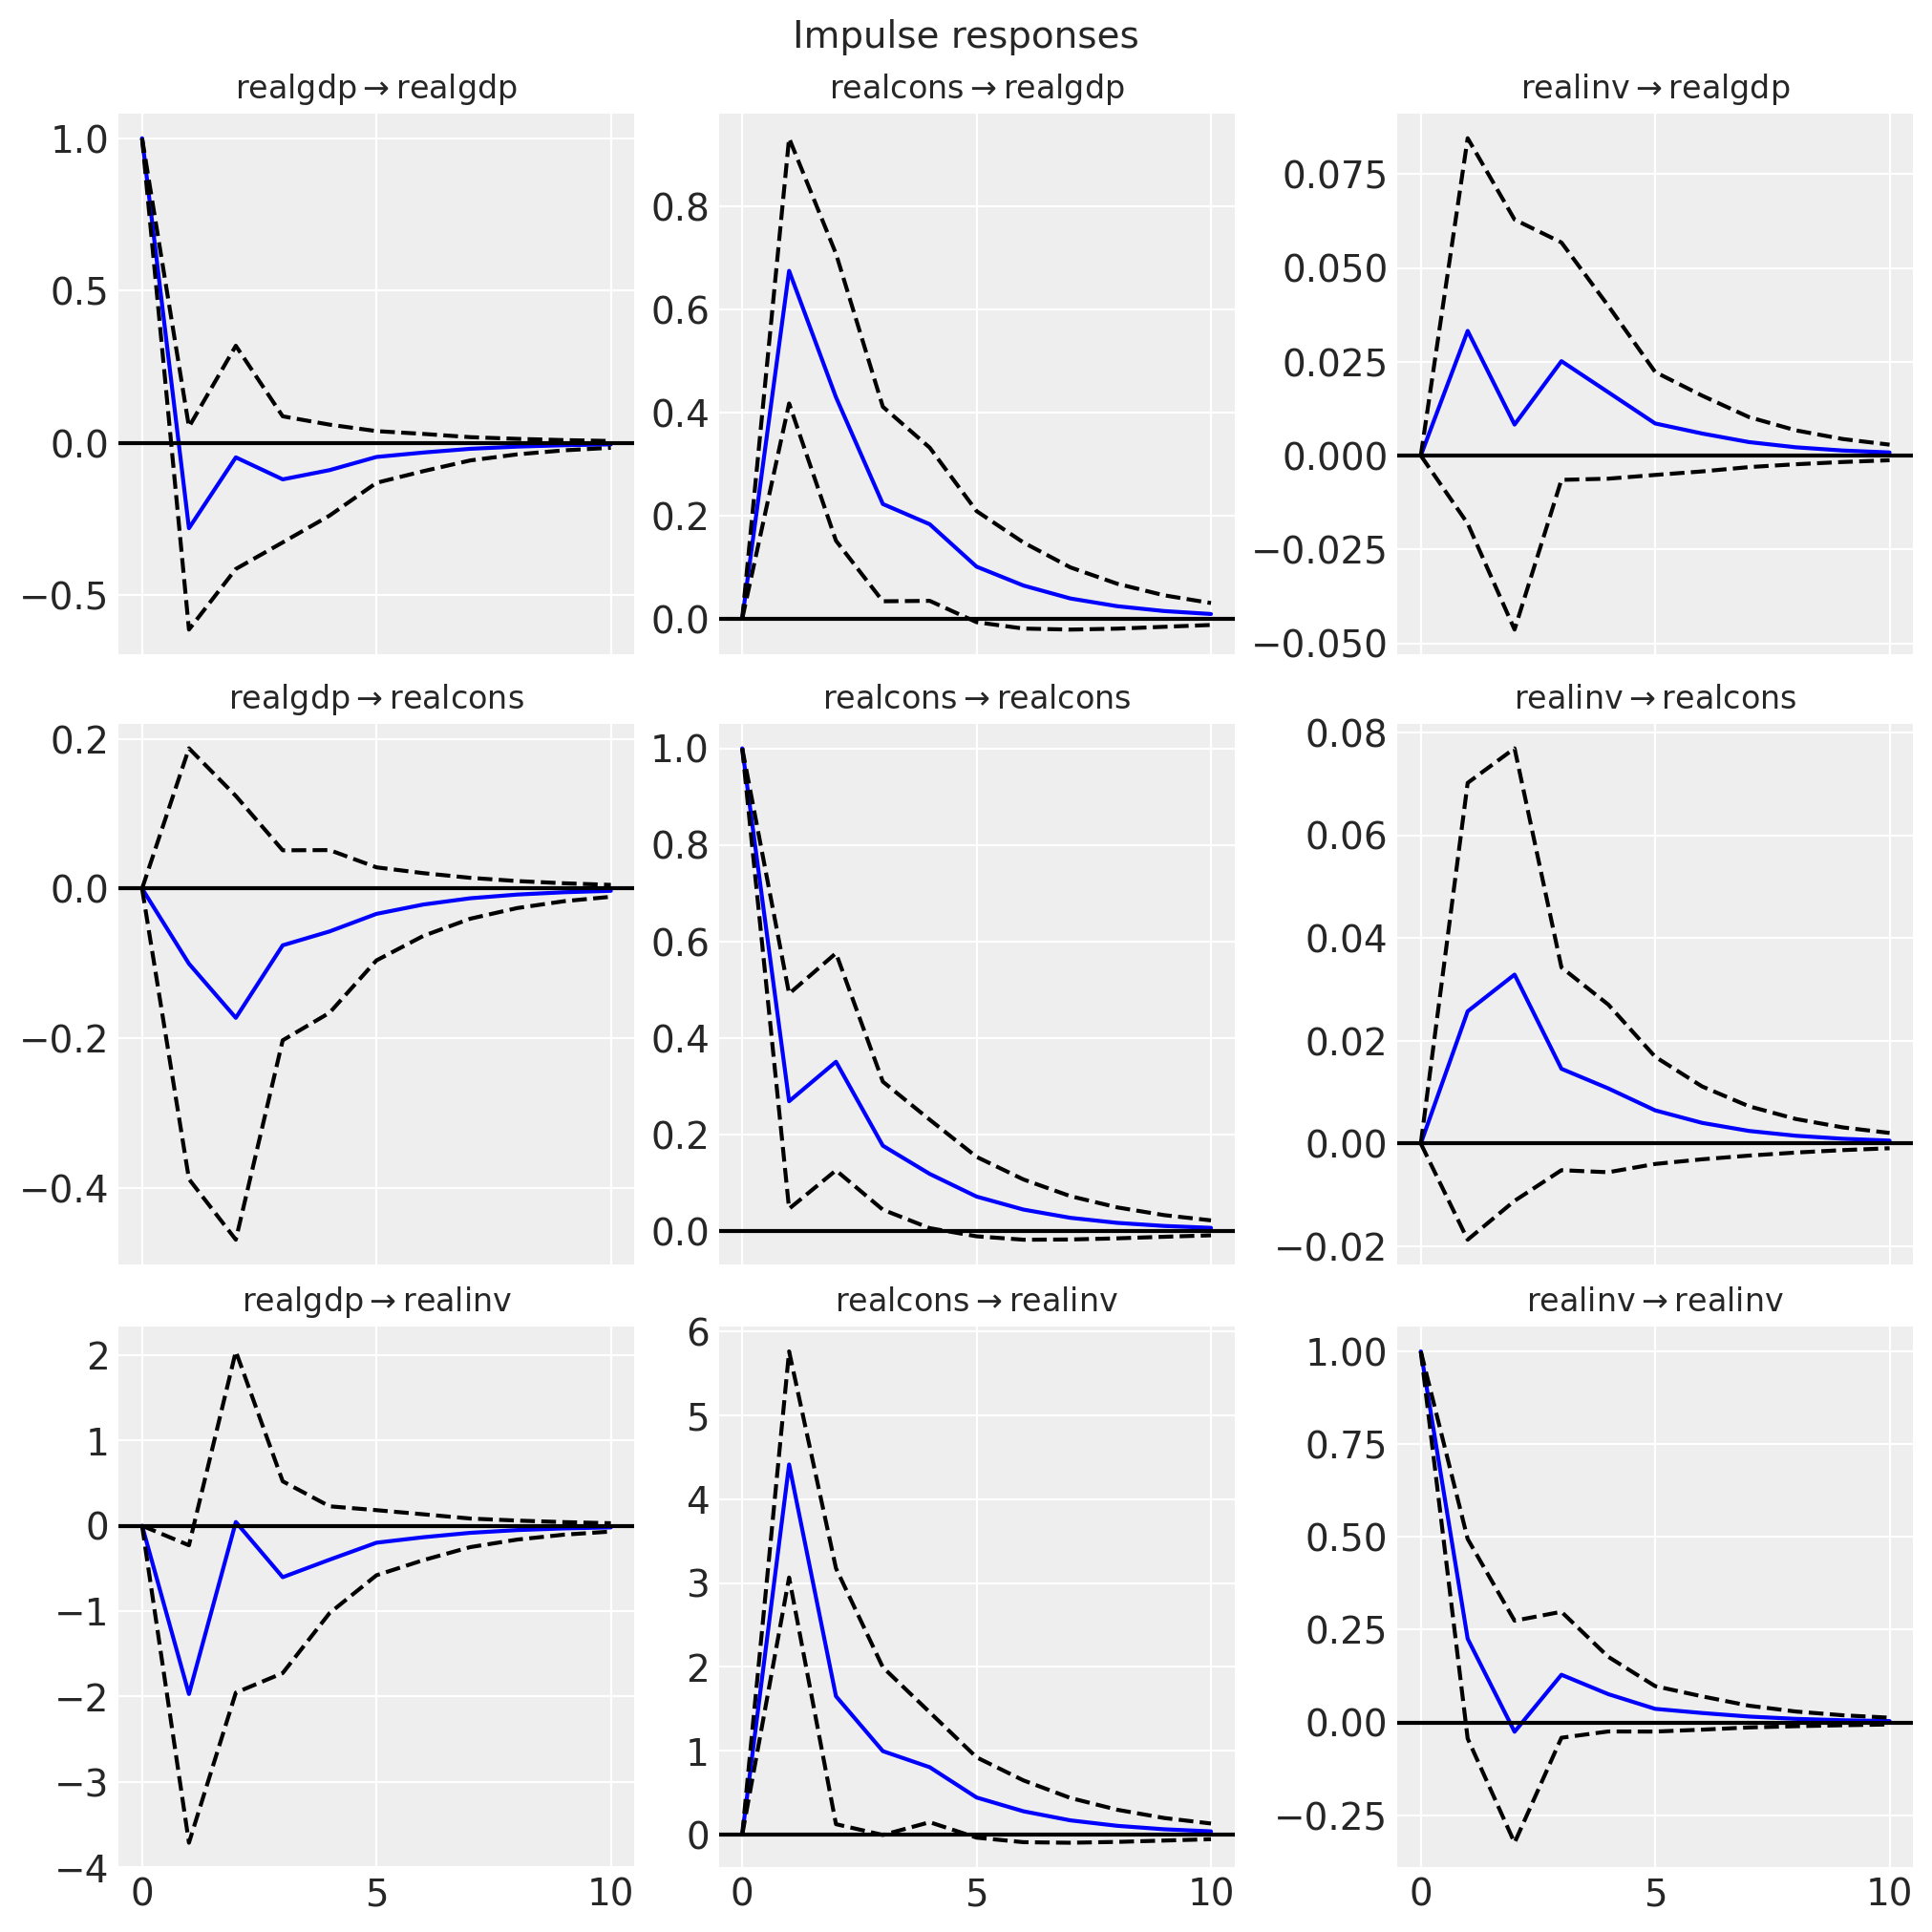

In [23]:
fig = var_irf.plot(orth=False)

### Orthogonalized vs Non-Orthogonalized IRFs

An important distinction in VAR analysis is between **orthogonalized** and **non-orthogonalized** impulse response functions. Let's understand what this means and why it matters.

#### The Problem: Contemporaneous Correlation

In our VAR model, the error terms $\varepsilon_t$ are typically **correlated** across variables. For example:
- A shock to GDP and a shock to consumption might happen simultaneously
- The error covariance matrix $\Sigma = E[\varepsilon_t \varepsilon_t']$ is usually **not diagonal**

This creates a problem for interpretation: when we "shock" one variable, we're implicitly shocking correlated variables too!

#### Non-Orthogonalized IRFs (What We Computed)

Our `compute_irf` function computes **non-orthogonalized IRFs** using the formula:

$$\Psi_i = \sum_{j=1}^{\min(i,p)} \Psi_{i-j} \Phi_j$$

**Interpretation:** These IRFs answer: *"What happens if variable j experiences a one-unit shock, given the historical correlation structure of shocks?"*

**Advantages:**
- Simple to compute (just the VAR coefficients)
- No additional identifying assumptions needed
- Useful for forecasting and variance decomposition

**Disadvantages:**
- Hard to interpret as "pure" shocks due to contemporaneous correlation
- IRFs depend on variable ordering (in some contexts)

#### Orthogonalized IRFs (Cholesky Decomposition)

To get **orthogonalized IRFs**, we use the Cholesky decomposition of the error covariance matrix $\Sigma = LL^{T}$, where $L$ is lower triangular. Then:

$$\Psi_i^{\text{orth}} = \Psi_i \cdot L$$

In statsmodels, this is obtained with `irf(orth=True)` (the default).

**Interpretation:** These IRFs answer: *"What happens if we apply a one-standard-deviation orthogonal shock to variable j, holding other orthogonal shocks constant?"*

**Advantages:**
- Shocks are uncorrelated by construction
- Easier to interpret as "structural" shocks
- Standard in macroeconomics literature

**Disadvantages:**
- Depends on variable ordering (Cholesky decomposition is not unique)
- Requires identifying assumptions (ordering = causal structure)
- The first variable is assumed to affect all others contemporaneously, but not vice versa

## Summary

In this notebook, we successfully implemented a Bayesian Vector Autoregressive (VAR) model using NumPyro and validated it against the established `statsmodels` implementation. Our key achievements include:

1. **Model Specification & Inference**: We built a flexible $VAR(p)$ model in NumPyro using `jax.lax.scan` for efficient time series dynamics, leveraging proper Bayesian priors (Normal for coefficients, LKJ for correlation structure) and MCMC sampling via NUTS. This can serve as a component to be combined with more complex models. For example, adding covariates and additional likelihoods.

2. **Forecasting**: The model generates multi-step-ahead forecasts with full posterior uncertainty quantification. Our NumPyro forecasts closely match the `statsmodels` point predictions. We also show how to generate credible intervals for the forecasts.

3. **Impulse Response Functions**: We implemented the recursive $MA(\infty)$ representation algorithm to compute IRFs using JAX's functional programming tools (`lax.scan`, `vmap`, `jit`). The resulting IRFs are identical to `statsmodels` outputs, validating our implementation.

**Key Advantages of the NumPyro Approach:**
- Full Bayesian inference with uncertainty quantification for all parameters and predictions
- Scalable computation through JAX's JIT compilation and vectorization
- Flexible specification allowing easy extensions (e.g., hierarchical priors, time-varying coefficients)

This implementation provides a solid foundation for more advanced Bayesian time series modeling in economic and financial applications among other domains.